In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC
import time
import json
import os

# PARTE 01 - Obter os links e informações das vagas

In [2]:
# Configura o caminho para o ChromeDriver
chrome_driver_path = 'F:\\PythonScripts\\chromedriver64\\chromedriver.exe'
service = Service(chrome_driver_path)

### Usuário e senha do portal Gupy

In [3]:
# Caminho do arquivo JSON
file_path_user = 'F:\\PythonScripts\\chromedriver64\\access_gupy.json'

# Verifica se o arquivo existe e não está vazio
if os.path.exists(file_path_user) and os.path.getsize(file_path_user) > 0:
    try:
        # Abrir e ler o arquivo JSON
        with open(file_path_user, 'r') as f:
            dados = json.load(f)
            
            # Armazenar os valores de usuario e senha em variáveis
            usuario = dados['usuario']
            senha = dados['senha']
            
            # Exibir com asteriscos
            senha_mascarada = '*' * len(senha)
            user_mascarado = '*' * len(usuario)
            
            print("Dados carregados com sucesso")
            print(f"Usuário: {user_mascarado}")
            print(f"Senha: {senha_mascarada}")
            
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar o JSON: {e}")
else:
    print("Arquivo JSON não existe ou está vazio.")

Dados carregados com sucesso
Usuário: *******************
Senha: ***********


In [5]:
# Inicializa o WebDriver do Chrome
driver = webdriver.Chrome(service=service)

# Abre a página de login
driver.get("https://portal.gupy.io/users/sign_in")

# Aguarda a página carregar
time.sleep(15)

# Preenche os campos de login
username = driver.find_element(By.ID, 'username')
password = driver.find_element(By.ID, 'password-input')

username.send_keys(usuario)
password.send_keys(senha)
password.send_keys(Keys.RETURN)

# Aguarda o login ser processado
time.sleep(5)

### Pega os links e salva em um json

In [4]:
scrape_url = 'https://portal.gupy.io/job-search/term=dados'
driver.get(scrape_url)

In [6]:
# Aguarda a página carregar completamente
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
time.sleep(5)  # Tempo extra para garantir que tudo foi carregado

In [7]:
# Rola a página até o final várias vezes para carregar mais elementos
for _ in range(100):  # Ajuste o range conforme necessário
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)  # Aguarda o carregamento dos novos elementos

In [8]:
# Extrai o HTML da página
page_source = driver.page_source

In [9]:
import requests
from bs4 import BeautifulSoup

In [10]:
# Analisa o HTML com BeautifulSoup
soup = BeautifulSoup(page_source, 'html.parser')

In [11]:
# Encontra todos os links de vagas
job_links = []
for link in soup.find_all('a', href=True):
    href = link['href']
    job_links.append(href)

# Remove duplicados
job_links = list(set(job_links))

# Exibe os links encontrados
print(f'{len(job_links)} links de vagas encontrados:')
for job_link in job_links:
    print(job_link)

# Salva os links em um arquivo JSON
with open('links.json', 'w', encoding='utf-8') as f:
    json.dump(job_links, f, ensure_ascii=False, indent=4)


24 links de vagas encontrados:
https://genteraizen.gupy.io/candidates/applications/473233112
/my/applications
https://login.gupy.io/candidates/curriculum
javascript:void(0)
https://sesisenaial.gupy.io/candidates/applications/473231172
https://login.gupy.io/candidates/profile/account-data
#main-content
https://vagas_confi_denciais.gupy.io/candidates/applications/473229095
https://sejaefi.gupy.io/candidates/applications/474231744
https://amolore.gupy.io/candidates/applications/473326625
https://globo.gupy.io/candidates/applications/473871326
https://login.gupy.io/candidates/gupy-privacy
https://vemserolxbrasil.gupy.io/candidates/applications/473860455
https://colegiosigma.gupy.io/candidates/applications/473232676
https://www.gupy.io/aviso-de-privacidade-site
https://vibraenergia.gupy.io/candidates/applications/473231966
https://sinqia.gupy.io/candidates/applications/473230511
https://nzn.gupy.io/candidates/applications/473323761
https://www.gupy.io/aviso-de-cookies?_gl=1*1rylxvw*_gcl_au*

### Pegar os dados de cada um dos links

In [13]:
# Verifica se o arquivo existe e seu tamanho
file_path = 'C:\\Users\\rpime\\airflow\\links.json'
if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
    with open(file_path, 'r') as f:
        try:
            urls = json.load(f)
            print("URLs carregados com sucesso")
        except json.JSONDecodeError:
            print("Erro ao decodificar o JSON, o arquivo pode estar vazio ou corrompido.")
else:
    print("Arquivo JSON não existe ou está vazio.")

URLs carregados com sucesso


In [14]:
class JobScraper:
    def __init__(self, urls):
        self.urls = urls
        self.jobs_data = []

    def scrape_jobs(self):
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
        for url in self.urls:
            try:
                driver.get(url)
                time.sleep(3)  # Tempo para a página carregar, ajuste conforme necessário
                
                job_data = {}
                job_data['url'] = url
                job_data['empresa'] = self.get_company_name(url)
                job_data['titulo'] = self.get_text_by_tag(driver, 'h1', By.TAG_NAME)
                job_data['data_publicacao'] = self.get_text_by_partial_class(driver, 'Published on')
                job_data['data_limite'] = self.get_text_by_partial_class(driver, 'Applications open until')
                job_data['local_trabalho'] = self.get_text_by_class(driver, 'sc-dfd42894-0 bzQMFp')
                job_data['tipo_vaga'] = self.get_text_by_class(driver, 'sc-dfd42894-0 bzQMFp', index=1)
                job_data['modelo_trabalho'] = self.get_text_by_class(driver, 'sc-dfd42894-0 bzQMFp', index=2)
                job_data['descricao'] = self.get_text_by_data_testid(driver, 'section-Job description-title')
                job_data['responsabilidades'] = self.get_text_by_data_testid(driver, 'section-Responsibilities and assignments-title')
                job_data['requisitos'] = self.get_text_by_data_testid(driver, 'section-Requirements and qualifications-title')
                job_data['informacoes_adicionais'] = self.get_text_by_data_testid(driver, 'section-Additional information-title')
                job_data['etapas_processo'] = self.get_text_by_data_testid(driver, 'section-Process stages-title')

                self.jobs_data.append(job_data)
            
            except Exception as e:
                print(f"Erro ao processar URL {url}: {e}")
                continue  # Ignora esta URL e passa para a próxima

        #driver.quit()

    def get_company_name(self, url):
        return url.split('.')[0].split('//')[-1]

    def get_text_by_tag(self, driver, tag, by=By.TAG_NAME, index=0):
        try:
            elements = driver.find_elements(by, tag)
            if elements and len(elements) > index:
                return elements[index].text
        except Exception as e:
            print(f"Erro ao obter texto por tag {tag}: {e}")
        return ''

    def get_text_by_partial_class(self, driver, partial_text):
        try:
            elements = driver.find_elements(By.CSS_SELECTOR, f'p[class*="sc-ccd5d36-11"]')
            for element in elements:
                if partial_text in element.text:
                    return element.text
        except Exception as e:
            print(f"Erro ao obter texto por classe parcial {partial_text}: {e}")
        return ''

    def get_text_by_class(self, driver, class_name, index=0):
        try:
            elements = driver.find_elements(By.CLASS_NAME, class_name)
            if elements and len(elements) > index:
                return elements[index].text
        except Exception as e:
            print(f"Erro ao obter texto por classe {class_name}: {e}")
        return ''

    def get_text_by_data_testid(self, driver, data_testid):
        try:
            element = driver.find_element(By.CSS_SELECTOR, f'[data-testid="{data_testid}"]')
            return element.find_element(By.XPATH, '..').text
        except Exception as e:
            print(f"Erro ao obter texto por data-testid {data_testid}: {e}")
        return ''

    def save_to_json(self, filename):
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.jobs_data, f, ensure_ascii=False, indent=4)

In [15]:
if __name__ == "__main__":
   #  Carregar os URLs das vagas do JSON gerado anteriormente
   # with open('C:\\Users\\rpime\\airflow\\gupy_links2.json', 'r') as f:
   #     urls = json.load(f)

    scraper = JobScraper(urls)
    scraper.scrape_jobs()
    scraper.save_to_json('jobs_data.json')

Erro ao obter texto por data-testid section-Responsibilities and assignments-title: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[data-testid="section-Responsibilities and assignments-title"]"}
  (Session info: chrome=127.0.6533.100); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x008D8923+23283]
	(No symbol) [0x0089E934]
	(No symbol) [0x007D0733]
	(No symbol) [0x0081326F]
	(No symbol) [0x008134AB]
	(No symbol) [0x0084EE42]
	(No symbol) [0x00834464]
	(No symbol) [0x0084CB8D]
	(No symbol) [0x008341B6]
	(No symbol) [0x00808017]
	(No symbol) [0x0080890D]
	GetHandleVerifier [0x009CA5E3+1013683]
	GetHandleVerifier [0x009D3E3C+1052684]
	GetHandleVerifier [0x009CD4A4+1025652]
	GetHandleVerifier [0x008FEA2B+179195]
	(No symbol) [0x008A6833]
	(No symbol) [0x008A3198]
	(No symbol) [0x008A3337]
	(No symbol) [0x0089B4BE]
	Ba

In [16]:
# Fecha o navegador
driver.quit()

# PARTE 02 - Analisar os dados Coletados

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
df = pd.read_json('C:\\Users\\rpime\\airflow\\jobs_data.json')
print(f"O DataFrame tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
df.head()


O DataFrame tem 679 linhas e 13 colunas.


,url,empresa,titulo,data_publicacao,data_limite,local_trabalho,tipo_vaga,modelo_trabalho,descricao,responsabilidades,requisitos,informacoes_adicionais,etapas_processo
0,https://vemproitau.gupy.io/job/eyJqb2JJZCI6NzI...,vemproitau,Analista de Dados - Sênior - Câmbio,"Published on JUNE 07, 2024",,,,,JOB DESCRIPTION\nSobre GM&T\n\nA área de Globa...,RESPONSIBILITIES AND ASSIGNMENTS\ngeração e ma...,REQUIREMENTS AND QUALIFICATIONS\nCompetências:...,"ADDITIONAL INFORMATION\n\nCurtiu? Então, Vamos...",PROCESS STAGES\nStep 1: Registration\n1\nRegis...
1,https://estagiomercantil.gupy.io/job/eyJqb2JJZ...,estagiomercantil,ESTÁGIO - MONITORAMENTO DE OPERAÇÕES DE EMPRÉS...,"Published on JULY 17, 2024",,,,,"JOB DESCRIPTION\n#VEMSERMERCANTIL\n\nEi, você!...",,,ADDITIONAL INFORMATION\nEssas são as etapas do...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...
2,https://keeggo.gupy.io/job/eyJqb2JJZCI6NzQ4Njg...,keeggo,Analista de Banco de Dados Senior | Oracle,"Published on JULY 17, 2024","Applications open until SEPTEMBER 17, 2024",,,,JOB DESCRIPTION\nVocê é uma pessoa que atua em...,RESPONSIBILITIES AND ASSIGNMENTS\nEstamos à pr...,REQUIREMENTS AND QUALIFICATIONS\nRequisitos\nE...,ADDITIONAL INFORMATION\n\n🍽️ Cartão Flex Caju ...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...
3,https://yamaha.gupy.io/job/eyJqb2JJZCI6NzM4MTk...,yamaha,ANALISTA DE PROCESSOS E PROTEÇÃO DE DADOS PL,"Published on JULY 16, 2024",,,,,JOB DESCRIPTION\nEstá preparado para enfrentar...,RESPONSIBILITIES AND ASSIGNMENTS\nAuxiliar e r...,REQUIREMENTS AND QUALIFICATIONS\nConhecimento ...,ADDITIONAL INFORMATION\nEducação e Certificaçõ...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...
4,https://minsait.gupy.io/job/eyJqb2JJZCI6NzQ2OD...,minsait,Administrador de Banco de Dados,"Published on JULY 15, 2024",,,,,JOB DESCRIPTION\nSomos aproximadamente 50k Min...,RESPONSIBILITIES AND ASSIGNMENTS\n💼 Responsabi...,REQUIREMENTS AND QUALIFICATIONS\n📚 Requisitos:...,ADDITIONAL INFORMATION\nTRABALHE NA MINSAIT\n\...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...


In [14]:
print(df.columns)


Index(['url', 'empresa', 'titulo', 'data_publicacao', 'data_limite',
       'local_trabalho', 'tipo_vaga', 'modelo_trabalho', 'descricao',
       'responsabilidades', 'requisitos', 'informacoes_adicionais',
       'etapas_processo'],
      dtype='object')


### Inserindo Categoria e indice

In [15]:
import pandas as pd
import json

# Carregar os dados do JSON existente
df = pd.read_json('C:\\Users\\rpime\\airflow\\jobs_data.json')

# Categorias e palavras-chave associadas
categories = {
    'Analista': ['PROTEÇÃO DE DADOS','Analista', 'Análise de Dados', 'Analista de Dados', 'Pessoa Analista de Dados'],
    'Engenheiro': ['Engenheiro', 'Engenheiro de Dados', 'Pessoa Engenheira de Dados', 'Engenharia de Dados'],
    'Gerente': ['Gerente', 'Gerente de Dados', 'Gerente de Engenharia de Dados'],
    'Coordenador': ['Coordenador', 'Pessoa Coordenadora', 'Coordenador de Dados', 'Coordenação de Dados'],
    'Especialista': ['Especialista', 'Especialista de Dados', 'Pessoa Especialista em Dados', 'ESPECIALISTA EM CIÊNCIA DE DADOS'],
    'Cientista de Dados': ['ESPECIALISTA EM CIÊNCIA DE DADOS','Cientista de Dados', 'Pessoa Cientista de Dados', 'Cientista'],
    'Administrador de Dados': ['ADMINISTRADOR DE DADOS','Administrador de Dados', 'Pessoa Administradora de Dados', 'Admistrador'],
    'Administrador de Banco de Dados': ['Administrador de Banco de Dados', 'DBA', 'Administrador(a) de Banco de Dados'],
    'Estagiário': ['Estágio', 'Estagiário', 'Pessoa Estagiária', 'Estágio em Dados', 'Estágio em Análise de Dados'],
    'Consultor': ['Consultor', 'Pessoa Consultora', 'Consultoria de Dados', 'ESTÁGIO - MONITORAMENTO DE OPERAÇÕES DE EMPRÉSTIMOS'],
    'Auxiliar': ['Auxiliar', 'Pessoa Auxiliar'],
    'Arquiteto de Dados': ['Arquiteto de Dados', 'Arquitetura de Dados', 'Pessoa Arquiteto de Dados'],
    'Líder Técnico': ['Líder Técnico', 'Pessoa Líder Técnico', 'Tech Lead'],
    'Gerente de Projetos de Dados': ['Gerente de Projetos de Dados', 'Pessoa Gerente de Projetos de Dados'],
    'Analista de Segurança de Dados': ['Analista de Segurança de Dados', 'Segurança de Dados'],
    'Analista de Governança de Dados': ['Analista de Governança de Dados', 'Governança de Dados'],
    'Outros': []  # Para qualquer título que não se encaixe nas categorias acima
}

# Função para categorizar cada título de vaga
def categorize_title(title):
    for category, keywords in categories.items():
        if any(keyword in title for keyword in keywords):
            return category
    return 'Outros'

# Aplicar categorização
df['categoria'] = df['titulo'].apply(categorize_title)

# Adicionar um índice para cada vaga
df.reset_index(inplace=True)
df.rename(columns={"index": "id"}, inplace=True)

# Salvar em novo arquivo JSON
df.to_json('C:\\Users\\rpime\\airflow\\jobs_data_categ.json', orient='records', indent=4, force_ascii=False)


In [22]:
# Carregar os dados
df_categ = pd.read_json('C:\\Users\\rpime\\airflow\\jobs_data_categ.json')
print(df.columns)

Index(['url', 'empresa', 'titulo', 'data_publicacao', 'data_limite',
       'local_trabalho', 'tipo_vaga', 'modelo_trabalho', 'descricao',
       'responsabilidades', 'requisitos', 'informacoes_adicionais',
       'etapas_processo'],
      dtype='object')


In [23]:
df_categ.head()

,id,url,empresa,titulo,data_publicacao,data_limite,local_trabalho,tipo_vaga,modelo_trabalho,descricao,responsabilidades,requisitos,informacoes_adicionais,etapas_processo,categoria
0,0,https://vemproitau.gupy.io/job/eyJqb2JJZCI6NzI...,vemproitau,Analista de Dados - Sênior - Câmbio,"Published on JUNE 07, 2024",,,,,JOB DESCRIPTION\nSobre GM&T\n\nA área de Globa...,RESPONSIBILITIES AND ASSIGNMENTS\ngeração e ma...,REQUIREMENTS AND QUALIFICATIONS\nCompetências:...,"ADDITIONAL INFORMATION\n\nCurtiu? Então, Vamos...",PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Analista
1,1,https://estagiomercantil.gupy.io/job/eyJqb2JJZ...,estagiomercantil,ESTÁGIO - MONITORAMENTO DE OPERAÇÕES DE EMPRÉS...,"Published on JULY 17, 2024",,,,,"JOB DESCRIPTION\n#VEMSERMERCANTIL\n\nEi, você!...",,,ADDITIONAL INFORMATION\nEssas são as etapas do...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Consultor
2,2,https://keeggo.gupy.io/job/eyJqb2JJZCI6NzQ4Njg...,keeggo,Analista de Banco de Dados Senior | Oracle,"Published on JULY 17, 2024","Applications open until SEPTEMBER 17, 2024",,,,JOB DESCRIPTION\nVocê é uma pessoa que atua em...,RESPONSIBILITIES AND ASSIGNMENTS\nEstamos à pr...,REQUIREMENTS AND QUALIFICATIONS\nRequisitos\nE...,ADDITIONAL INFORMATION\n\n🍽️ Cartão Flex Caju ...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Analista
3,3,https://yamaha.gupy.io/job/eyJqb2JJZCI6NzM4MTk...,yamaha,ANALISTA DE PROCESSOS E PROTEÇÃO DE DADOS PL,"Published on JULY 16, 2024",,,,,JOB DESCRIPTION\nEstá preparado para enfrentar...,RESPONSIBILITIES AND ASSIGNMENTS\nAuxiliar e r...,REQUIREMENTS AND QUALIFICATIONS\nConhecimento ...,ADDITIONAL INFORMATION\nEducação e Certificaçõ...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Analista
4,4,https://minsait.gupy.io/job/eyJqb2JJZCI6NzQ2OD...,minsait,Administrador de Banco de Dados,"Published on JULY 15, 2024",,,,,JOB DESCRIPTION\nSomos aproximadamente 50k Min...,RESPONSIBILITIES AND ASSIGNMENTS\n💼 Responsabi...,REQUIREMENTS AND QUALIFICATIONS\n📚 Requisitos:...,ADDITIONAL INFORMATION\nTRABALHE NA MINSAIT\n\...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Administrador de Banco de Dados


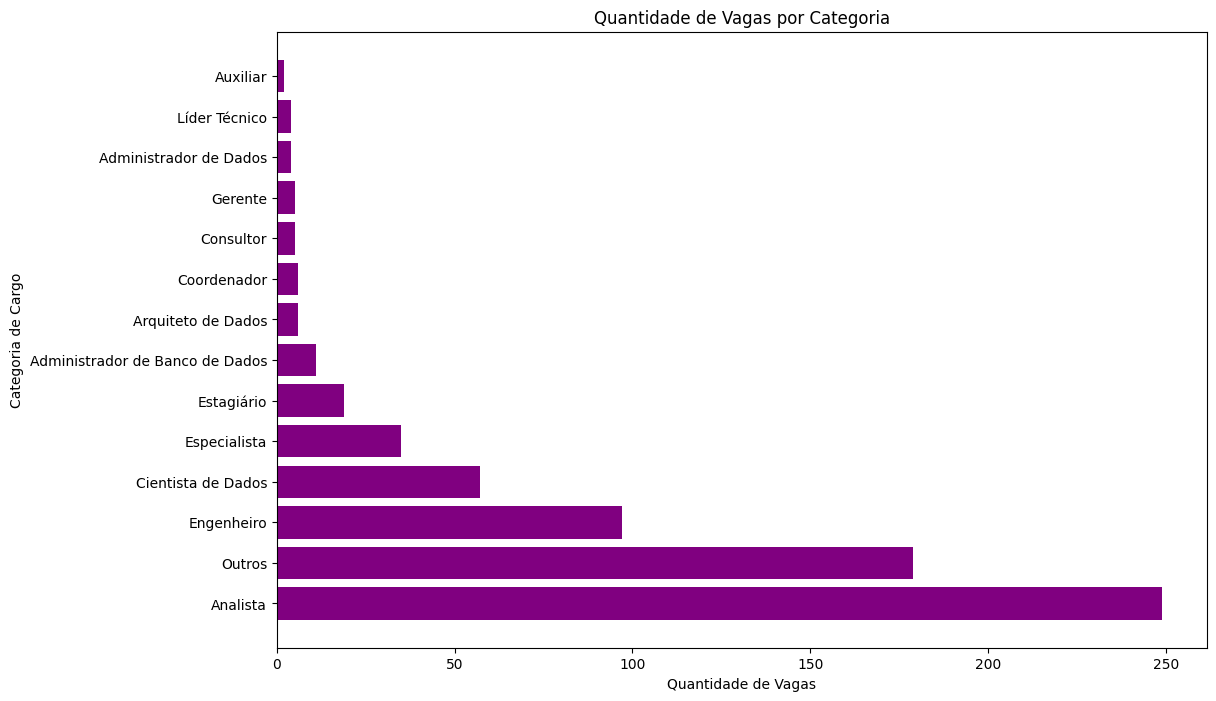

In [24]:
# Contagem das vagas por categoria
category_counts = df_categ['categoria'].value_counts()

# Exibir os dados em um gráfico de barras horizontais
plt.figure(figsize=(12, 8))
plt.barh(category_counts.index, category_counts.values, color='purple')
plt.xlabel('Quantidade de Vagas')
plt.ylabel('Categoria de Cargo')
plt.title('Quantidade de Vagas por Categoria')
plt.show()

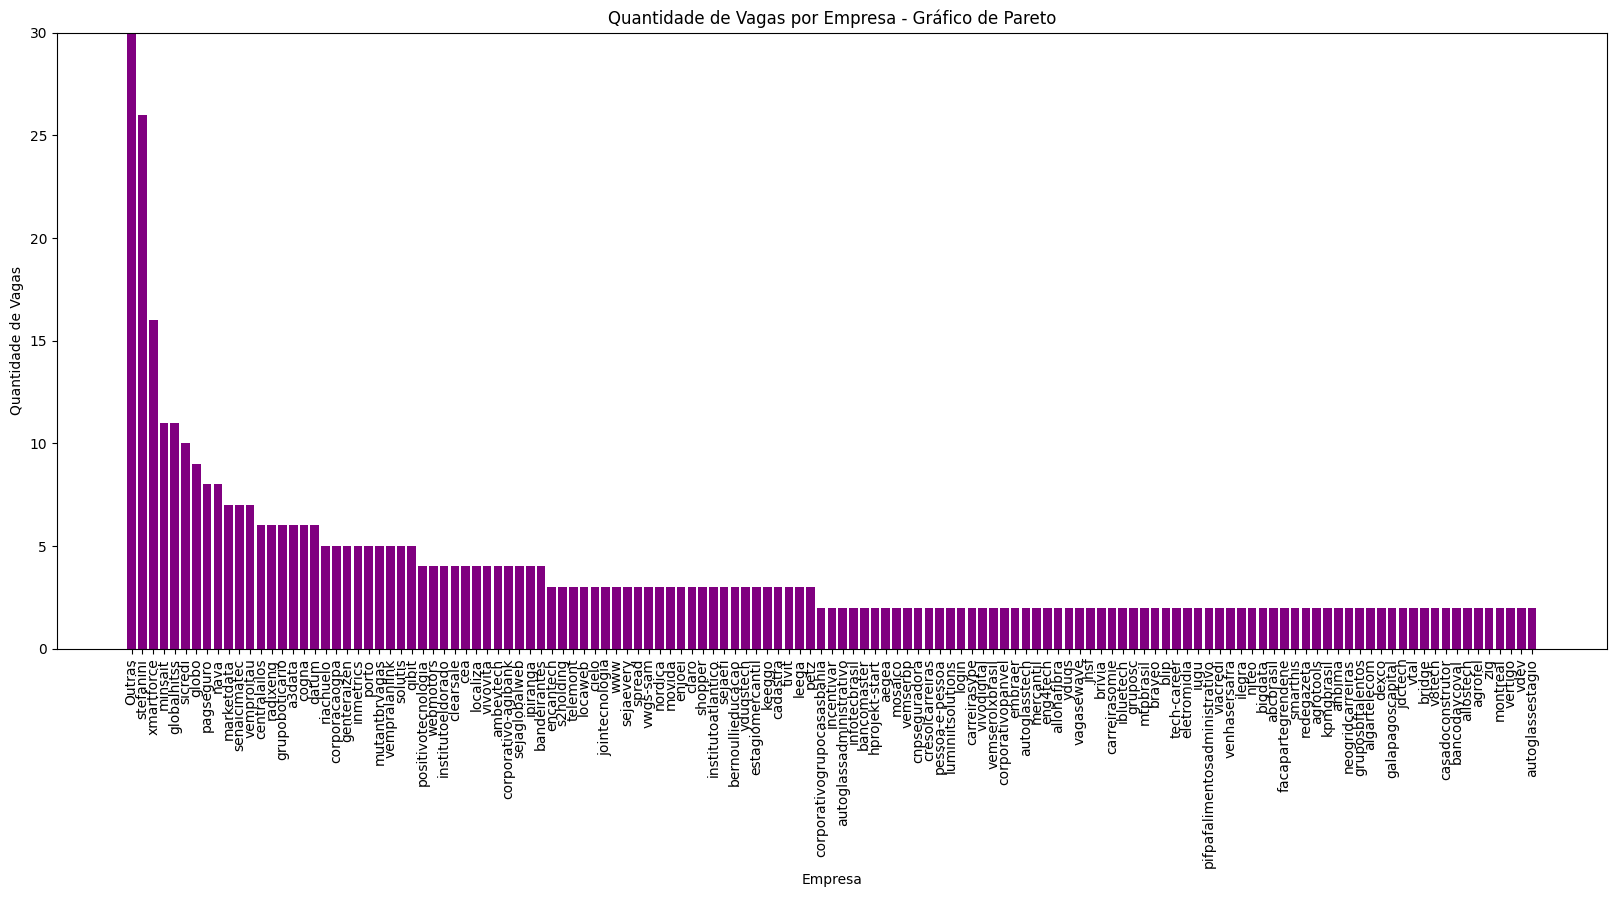

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
df_categ = pd.read_json('C:\\Users\\rpime\\airflow\\jobs_data_categ.json')

# Contagem das vagas por Empresa
category_counts = df_categ['empresa'].value_counts()

# Identificar empresas com apenas uma vaga
small_companies = category_counts[category_counts == 1].index

# Agrupar empresas com apenas uma vaga na categoria "Outras"
df_categ['empresa'] = df_categ['empresa'].apply(lambda x: 'Outras' if x in small_companies else x)

# Recontar as vagas por empresa após agrupamento
category_counts_grouped = df_categ['empresa'].value_counts()

# Ordenar empresas por número de vagas
sorted_category_counts = category_counts_grouped.sort_values(ascending=False)

# Plotar Gráfico de Pareto
plt.figure(figsize=(20, 8))
plt.bar(sorted_category_counts.index, sorted_category_counts.values, color='purple')
plt.xticks(rotation=90)
plt.xlabel('Empresa')
plt.ylabel('Quantidade de Vagas')
plt.ylim(0, 30)  # Ajuste o eixo Y para exibir até 50
plt.yticks(range(0, 31, 5))  # Divisões de 10 em 10
plt.title('Quantidade de Vagas por Empresa - Gráfico de Pareto')
plt.show()



### REQUISITOS


In [33]:
import pandas as pd
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [35]:
# Carregar o arquivo JSON
df_categ = pd.read_json('C:\\Users\\rpime\\airflow\\jobs_data_categ.json')
df_categ.head()

,id,url,empresa,titulo,data_publicacao,data_limite,local_trabalho,tipo_vaga,modelo_trabalho,descricao,responsabilidades,requisitos,informacoes_adicionais,etapas_processo,categoria
0,0,https://vemproitau.gupy.io/job/eyJqb2JJZCI6NzI...,vemproitau,Analista de Dados - Sênior - Câmbio,"Published on JUNE 07, 2024",,,,,JOB DESCRIPTION\nSobre GM&T\n\nA área de Globa...,RESPONSIBILITIES AND ASSIGNMENTS\ngeração e ma...,REQUIREMENTS AND QUALIFICATIONS\nCompetências:...,"ADDITIONAL INFORMATION\n\nCurtiu? Então, Vamos...",PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Analista
1,1,https://estagiomercantil.gupy.io/job/eyJqb2JJZ...,estagiomercantil,ESTÁGIO - MONITORAMENTO DE OPERAÇÕES DE EMPRÉS...,"Published on JULY 17, 2024",,,,,"JOB DESCRIPTION\n#VEMSERMERCANTIL\n\nEi, você!...",,,ADDITIONAL INFORMATION\nEssas são as etapas do...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Consultor
2,2,https://keeggo.gupy.io/job/eyJqb2JJZCI6NzQ4Njg...,keeggo,Analista de Banco de Dados Senior | Oracle,"Published on JULY 17, 2024","Applications open until SEPTEMBER 17, 2024",,,,JOB DESCRIPTION\nVocê é uma pessoa que atua em...,RESPONSIBILITIES AND ASSIGNMENTS\nEstamos à pr...,REQUIREMENTS AND QUALIFICATIONS\nRequisitos\nE...,ADDITIONAL INFORMATION\n\n🍽️ Cartão Flex Caju ...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Analista
3,3,https://yamaha.gupy.io/job/eyJqb2JJZCI6NzM4MTk...,yamaha,ANALISTA DE PROCESSOS E PROTEÇÃO DE DADOS PL,"Published on JULY 16, 2024",,,,,JOB DESCRIPTION\nEstá preparado para enfrentar...,RESPONSIBILITIES AND ASSIGNMENTS\nAuxiliar e r...,REQUIREMENTS AND QUALIFICATIONS\nConhecimento ...,ADDITIONAL INFORMATION\nEducação e Certificaçõ...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Analista
4,4,https://minsait.gupy.io/job/eyJqb2JJZCI6NzQ2OD...,minsait,Administrador de Banco de Dados,"Published on JULY 15, 2024",,,,,JOB DESCRIPTION\nSomos aproximadamente 50k Min...,RESPONSIBILITIES AND ASSIGNMENTS\n💼 Responsabi...,REQUIREMENTS AND QUALIFICATIONS\n📚 Requisitos:...,ADDITIONAL INFORMATION\nTRABALHE NA MINSAIT\n\...,PROCESS STAGES\nStep 1: Registration\n1\nRegis...,Administrador de Banco de Dados


In [54]:
import pandas as pd
import re
from collections import Counter
import json

# Carregar o arquivo JSON
df_categ = pd.read_json('C:\\Users\\rpime\\airflow\\jobs_data_categ.json')

# Função para limpar e filtrar o texto
def clean_text(text):
    # Remove caracteres especiais, números e converte para minúsculas
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

# Aplicar a função de limpeza aos requisitos
df_categ['requisitos_limpos'] = df_categ['requisitos'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')

# Tokenizar o texto e contar a frequência das palavras
word_counts = Counter()

for text in df_categ['requisitos_limpos']:
    tokens = text.split()
    word_counts.update(tokens)

# Ordenar o dicionário por frequência em ordem decrescente
sorted_word_counts_dict = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

# Adicionar um índice ao dicionário
indexed_word_counts_dict = [{"id": i+1, word: count} for i, (word, count) in enumerate(sorted_word_counts_dict.items())]

# Salvar as contagens em um arquivo JSON com o índice
with open('requisitos_ordenados_indexado.json', 'w', encoding='utf-8') as f:
    json.dump(indexed_word_counts_dict, f, ensure_ascii=False, indent=4)

print(f"Análise completa. Frequência das palavras salva em 'requisitos_ordenados_indexado.json'.")




Análise completa. Frequência das palavras salva em 'requisitos_ordenados_indexado.json'.


In [55]:
df_categ_order = pd.read_json('C:\\Users\\rpime\\airflow\\requisitos_ordenados_indexado.json')
df_categ_order.head()

,id,de,e,em,dados,experiência,com,conhecimento,ou,para,...,vetorial,incluir,sdk,lammaindex,olamma,langsmith,langfuse,weight,bias,inferindo
0,1,5314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,2949.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,2610.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,1499.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,1234.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
hard_skills = {
    'Linguagens de Programação': [
        'python', 'sql', 'java', 'r', 'javascript', 'scala', 'shell', 'ruby', 'kotlin', 'vba', 
        'php', 'perl', 'c', 'c#', 'c++', 'go', 'rust', 'typescript', 'matlab', 'swift'
    ],
    'Ferramentas': [
        'excel', 'tableau', 'powerbi', 'spark', 'aws', 'azure', 'google', 'databricks', 'airflow', 
        'git', 'docker', 'kubernetes', 'hadoop', 'snowflake', 'redshift', 'looker', 'pyspark', 
        'pandas', 'tensorflow', 'keras', 'pytorch', 'scikit-learn', 'matplotlib', 'seaborn', 
        'jupyter', 'sqlalchemy', 'apache', 'superset', 'dbt', 'lookerstudio', 'datastudio'
    ],
    'Banco de Dados': [
        'oracle', 'sqlserver', 'mysql', 'nosql', 'mongodb', 'postgresql', 'bigquery', 'database', 
        'data warehouse', 'data lake', 'dwh', 'db2', 'sqlite', 'elasticsearch', 
        'cassandra', 'hbase', 'neo4j', 'firestore', 'dynamodb', 'redshift', 'mariadb', 'teradata'
    ],
    'Tecnologias e Arquiteturas': [
        'cloud', 'nuvem', 'ciência de dados', 'big data', 'devops', 'server', 'data science', 
        'machine learning', 'engenharia de dados', 'estatística', 'hadoop', 'dataops', 
        'datamarts', 'dataflow', 'lambda', 'datafactory', 'gcp', 'data lakehouse', 'pipeline', 
        'mlops', 'ai', 'ia', 'business intelligence', 'aplicações', 'sistemas distribuídos', 
        'arquiteto de dados', 'aws', 'gcp', 'azure', 'etl'
    ]
}


In [69]:
soft_skills = {
    'Comunicação': [
        'comunicação', 'relacionamento interpessoal', 'trabalho em equipe', 'negociação', 
        'apresentação', 'clareza', 'escrita', 'colaboração'
    ],
    'Gerenciamento de Tempo': [
        'organização', 'planejamento', 'gestão de tempo', 'priorização', 'disciplina', 
        'responsabilidade', 'autogestão', 'autonomia'
    ],
    'Resolução de Problemas': [
        'resolução de problemas', 'pensamento crítico', 'capacidade analítica', 
        'análise crítica', 'tomada de decisão', 'pensamento estratégico'
    ],
    'Liderança e Influência': [
        'liderança', 'influência', 'mentoria', 'gestão de pessoas', 'coordenação', 
        'motivação', 'inspiração', 'delegação'
    ],
    'Adaptabilidade': [
        'flexibilidade', 'adaptabilidade', 'resiliência', 'abertura a mudanças', 
        'capacidade de adaptação', 'agilidade'
    ],
    'Iniciativa': [
        'proatividade', 'iniciativa', 'curiosidade', 'inovação', 'empatia', 
        'orientação para resultados', 'entusiasmo'
    ],
    'Aprendizado Contínuo': [
        'aprendizado contínuo', 'autoaprendizado', 'curiosidade', 'atualização constante', 
        'vontade de aprender', 'desenvolvimento pessoal'
    ],
    'Criatividade': [
        'criatividade', 'inovação', 'pensamento inovador', 'originalidade', 
        'solução criativa', 'pensamento fora da caixa'
    ],
    'Trabalho sob Pressão': [
        'trabalho sob pressão', 'gestão de stress', 'resistência ao stress', 
        'equilíbrio emocional', 'foco em resultados', 'tolerância ao stress'
    ]
}


In [58]:
# Carregar o arquivo de requisitos ordenados
with open('requisitos_ordenados_indexado.json', 'r', encoding='utf-8') as file:
    requisitos = json.load(file)

# Função para categorizar uma palavra
def categorize_word(word):
    for category, words in hard_skills.items():
        if word in words:
            return 'hard skill'
    for category, words in soft_skills.items():
        if word in words:
            return 'soft skill'
    return 'não categorizado'

# Criar novo dicionário categorizado
categorizado = []
for item in requisitos:
    for word, count in item.items():
        if word != 'id':
            categoria = categorize_word(word)
            categorizado.append({'id': item['id'], 'palavra': word, 'frequência': count, 'categoria': categoria})

# Salvar o novo JSON categorizado
with open('requisitos_categorizados.json', 'w', encoding='utf-8') as f:
    json.dump(categorizado, f, ensure_ascii=False, indent=4)

print("Arquivo categorizado salvo como 'requisitos_categorizados.json'.")

Arquivo categorizado salvo como 'requisitos_categorizados.json'.


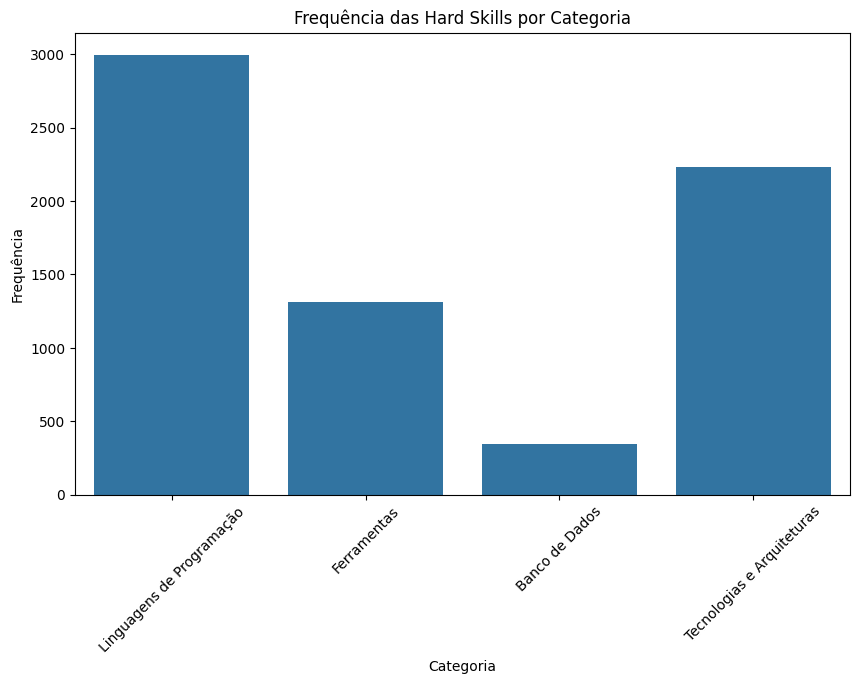

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

skill_counts = Counter()

for category, skills in hard_skills.items():
    for skill in skills:
        # Contar a ocorrência de cada skill no texto dos requisitos
        skill_counts[category] += df_categ['requisitos'].str.lower().str.contains(skill).sum()

# Convertendo o contador para DataFrame
df_skills = pd.DataFrame.from_dict(skill_counts, orient='index', columns=['Count']).reset_index()
df_skills.rename(columns={'index': 'Categoria'}, inplace=True)

# Plotar histogramas por categoria
plt.figure(figsize=(10, 6))
sns.barplot(data=df_skills, x='Categoria', y='Count')
plt.title('Frequência das Hard Skills por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.show()

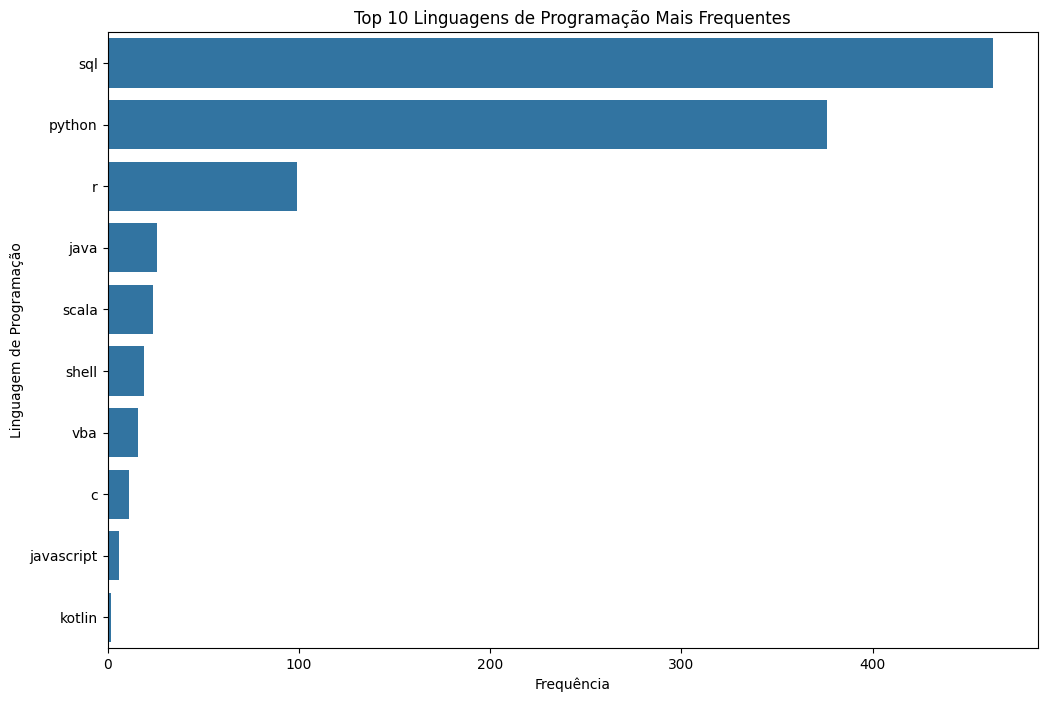

In [79]:
# Carregar o arquivo JSON categorizado
with open('requisitos_categorizados.json', 'r', encoding='utf-8') as f:
    requisitos_categorizados = json.load(f)

# Converter para DataFrame
df = pd.DataFrame(requisitos_categorizados)

# Filtrar apenas as linguagens de programação
linguagens_df = df[(df['categoria'] == 'hard skill') & (df['palavra'].isin(hard_skills['Linguagens de Programação']))]

# Somar as frequências de cada linguagem
linguagens_frequencia = linguagens_df.groupby('palavra')['frequência'].sum().sort_values(ascending=False)

# Selecionar as 10 linguagens mais frequentes
top_10_linguagens = linguagens_frequencia.head(10)

# Plotar o gráfico
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_linguagens.values, y=top_10_linguagens.index)
plt.title('Top 10 Linguagens de Programação Mais Frequentes')
plt.xlabel('Frequência')
plt.ylabel('Linguagem de Programação')
plt.show()


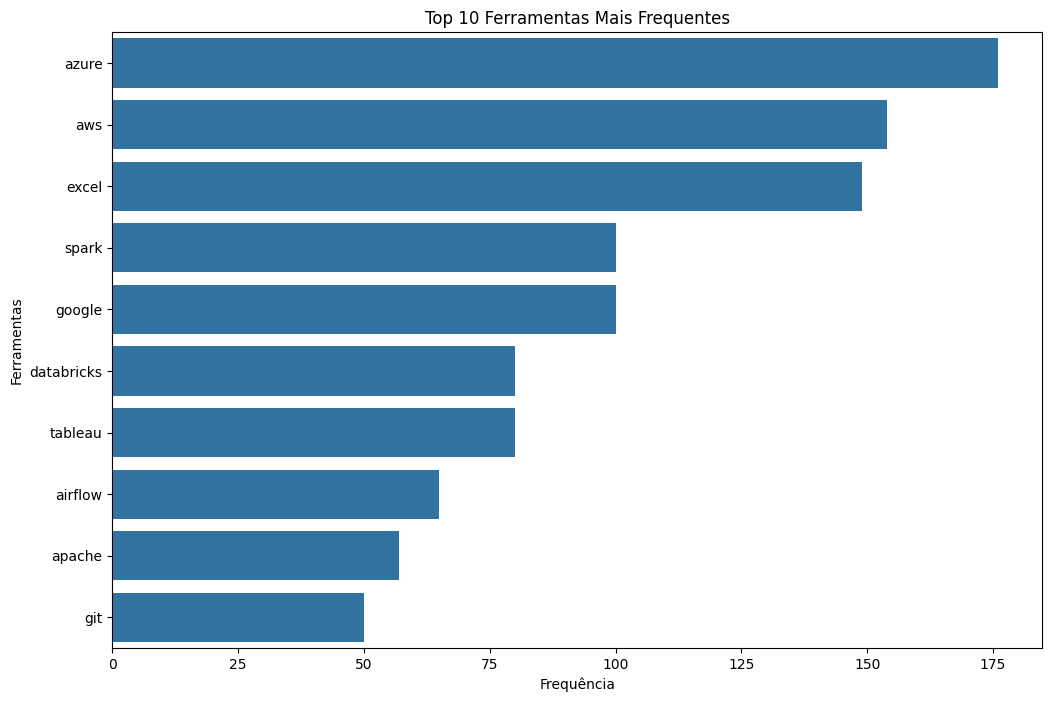

In [81]:
# Carregar o arquivo JSON categorizado
with open('requisitos_categorizados.json', 'r', encoding='utf-8') as f:
    requisitos_categorizados = json.load(f)

# Converter para DataFrame
df = pd.DataFrame(requisitos_categorizados)

# Filtrar apenas as linguagens de programação
ferramentas_df = df[(df['categoria'] == 'hard skill') & (df['palavra'].isin(hard_skills['Ferramentas']))]

# Somar as frequências de cada linguagem
ferramentas_frequencia = ferramentas_df.groupby('palavra')['frequência'].sum().sort_values(ascending=False)

# Selecionar as 10 linguagens mais frequentes
top_10_ferramentas = ferramentas_frequencia.head(10)

# Plotar o gráfico
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_ferramentas.values, y=top_10_ferramentas.index)
plt.title('Top 10 Ferramentas Mais Frequentes')
plt.xlabel('Frequência')
plt.ylabel('Ferramentas')
plt.show()

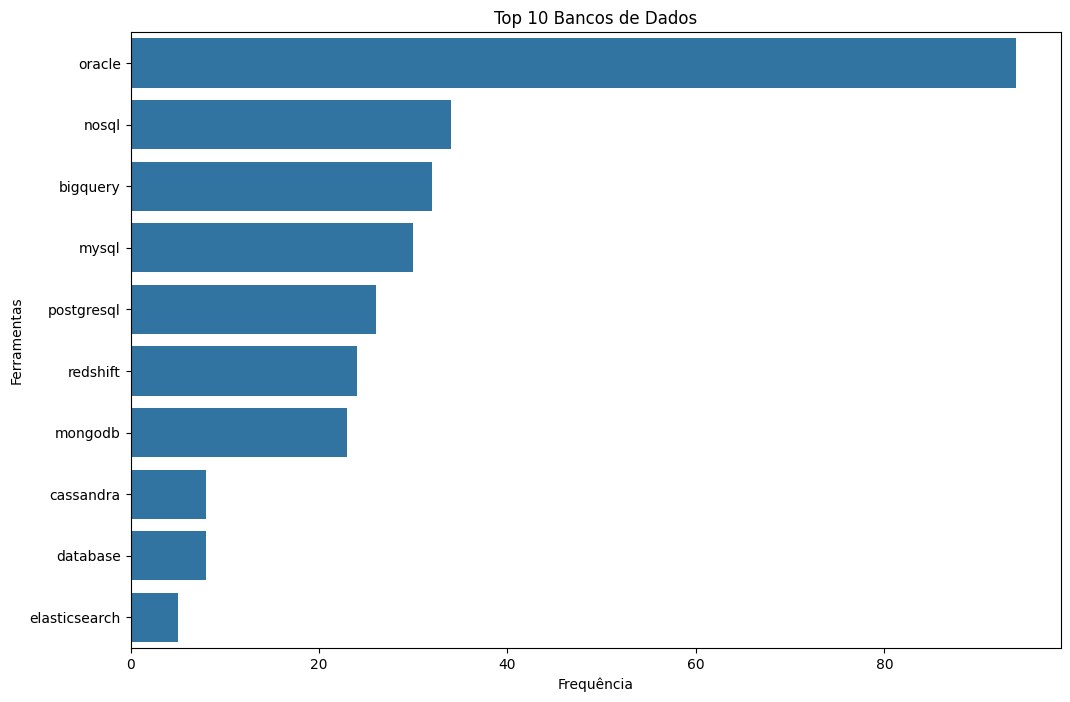

In [82]:
# Carregar o arquivo JSON categorizado
with open('requisitos_categorizados.json', 'r', encoding='utf-8') as f:
    requisitos_categorizados = json.load(f)

# Converter para DataFrame
df = pd.DataFrame(requisitos_categorizados)

# Filtrar apenas as linguagens de programação
Dbs_df = df[(df['categoria'] == 'hard skill') & (df['palavra'].isin(hard_skills['Banco de Dados']))]

# Somar as frequências de cada linguagem
Dbs_frequencia = Dbs_df.groupby('palavra')['frequência'].sum().sort_values(ascending=False)

# Selecionar as 10 linguagens mais frequentes
top_10_Dbs = Dbs_frequencia.head(10)

# Plotar o gráfico
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_Dbs.values, y=top_10_Dbs.index)
plt.title('Top 10 Bancos de Dados')
plt.xlabel('Frequência')
plt.ylabel('Ferramentas')
plt.show()

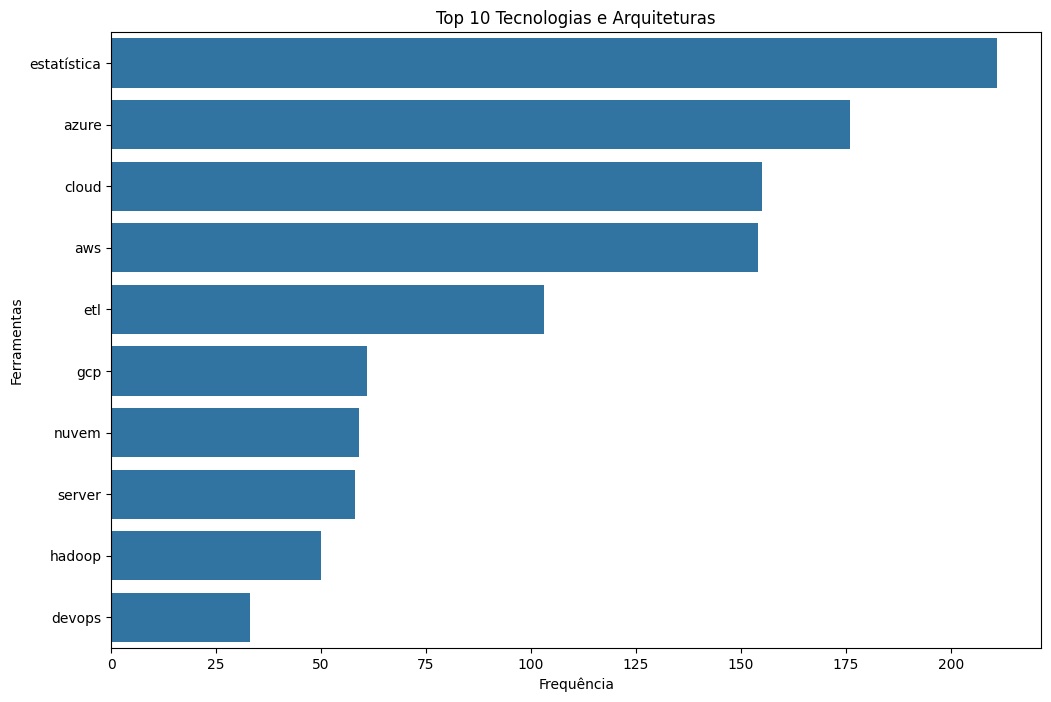

In [83]:
# Carregar o arquivo JSON categorizado
with open('requisitos_categorizados.json', 'r', encoding='utf-8') as f:
    requisitos_categorizados = json.load(f)

# Converter para DataFrame
df = pd.DataFrame(requisitos_categorizados)

# Filtrar apenas as linguagens de programação
tech_df = df[(df['categoria'] == 'hard skill') & (df['palavra'].isin(hard_skills['Tecnologias e Arquiteturas']))]

# Somar as frequências de cada linguagem
tech_frequencia = tech_df.groupby('palavra')['frequência'].sum().sort_values(ascending=False)

# Selecionar as 10 linguagens mais frequentes
top_10_tech = tech_frequencia.head(10)

# Plotar o gráfico
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_tech.values, y=top_10_tech.index)
plt.title('Top 10 Tecnologias e Arquiteturas')
plt.xlabel('Frequência')
plt.ylabel('Ferramentas')
plt.show()